## Data used: Titanic
Source: The principal source for data about Titanic passengers is the Encyclopedia Titanica. <br>
Predictors: Variables like "Age", "Sex", "Embarked", "Cabin" etc. <br>
Predictand: Output of the algorithm after it has been trained on our Titanic dataset.<br>
Target: "Survived" variable <br>

## Objective: To create a model predicting the survival of people onboard the Titanic.

In [1]:
#library(tidyverse)
library(ggplot2)
library(Amelia)
library(ggthemes)
library(randomForest)
library(mice)
library(scales)
library(dplyr)
library(caret)

Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.8.0, built: 2021-05-26)
## Copyright (C) 2005-2021 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin


Attaching package: ‘mice’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    cbind, rbind


Attaching package: ‘dplyr’

The following object is masked from ‘package:randomForest’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice


In [2]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

## Reading in the data

In [3]:
titanic_test <- read.csv(file='test.csv')
titanic_train <- read.csv(file='train.csv')
comp <- bind_rows(titanic_train,titanic_test)
str(comp)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 929 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 187 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


In [4]:
colSums(is.na(comp))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1           0           0

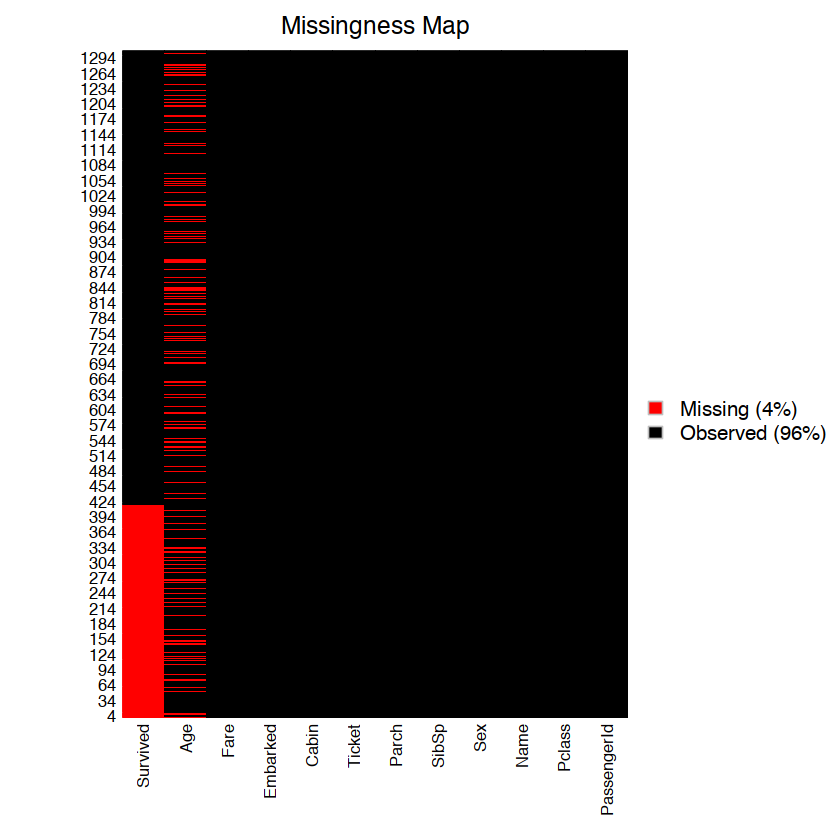

In [5]:
missmap(comp,col=c("red","black"))

In [6]:
table(comp$Survived)


  0   1 
549 342 

In [7]:
prop.table(table(comp$Survived))


        0         1 
0.6161616 0.3838384 

In [8]:
prop.table(table(comp$Sex, comp$Survived),1)

        
                 0         1
  female 0.2579618 0.7420382
  male   0.8110919 0.1889081

## Cleaning the data

### 1. Missing Embarkment values

In [9]:
#Missing Embarkment
which (comp$Embarked=='')

[1]  62 830

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

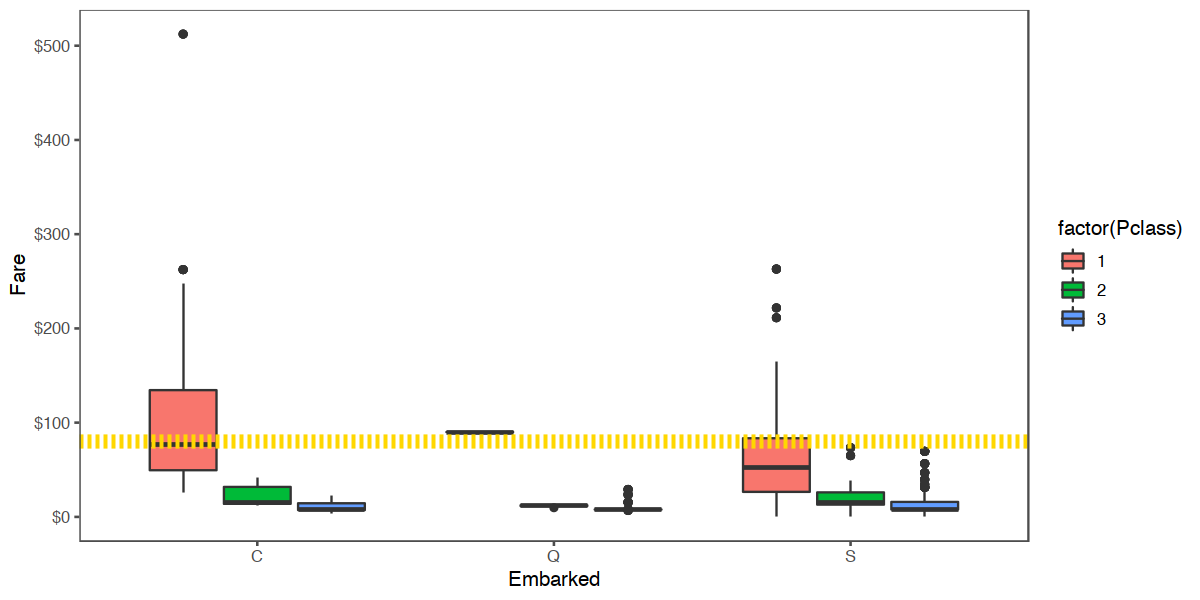

In [10]:
fig(10,5)
# Get rid of our missing passenger IDs
embarkfare <- comp %>%
  filter(PassengerId != 62 & PassengerId != 830)

# Use ggplot2 to visualize embarkment, passenger class, & median fare
ggplot(embarkfare, aes(x = Embarked, y = Fare, fill = factor(Pclass))) +
  geom_boxplot() +
  geom_hline(aes(yintercept=80), 
    colour='gold', linetype='dashed', lwd=3) +
  scale_y_continuous(labels=dollar_format()) +
  theme_few()

In [11]:
#Higher fare passengers mostly embarked from Charbourg or "C", hence changing NA to "C"
comp$Embarked[comp$Embarked=='']="C"

### 2. Missing Fare value

In [12]:
#Missing Fare value
which (is.na(comp$Fare))

[1] 1044

In [13]:
# Replacing missing fare value with median fare for class and embarkment
comp$Fare[1044] <- median(comp[comp$Pclass == '3' & comp$Embarked == 'S', ]$Fare, na.rm = TRUE)

In [14]:
colSums(comp=="")

PassengerId    Survived      Pclass        Name         Sex         Age 
          0          NA           0           0           0          NA 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0        1014           0

### 3. For Missing Age values

In [15]:
#Total missing age values
sum(is.na(comp$Age))

[1] 263

In [16]:
vfactors <- c('PassengerId','Pclass','Sex','Embarked',
                 'Survived','Parch','Fare')

comp[vfactors] <- lapply(comp[vfactors], function(x) as.factor(x))

set.seed(250)

# Perform mice imputation, excluding certain less-than-useful variables:
micemod <- mice(comp[, !names(comp) %in% c('PassengerId','Name','Ticket','Cabin','Survived','Parch','Fare')], method='rf') 


 iter imp variable
  1   1  Age
  1   2  Age
  1   3  Age
  1   4  Age
  1   5  Age
  2   1  Age
  2   2  Age
  2   3  Age
  2   4  Age
  2   5  Age
  3   1  Age
  3   2  Age
  3   3  Age
  3   4  Age
  3   5  Age
  4   1  Age
  4   2  Age
  4   3  Age
  4   4  Age
  4   5  Age
  5   1  Age
  5   2  Age
  5   3  Age
  5   4  Age
  5   5  Age


Warning message:
“Number of logged events: 25”

In [17]:
mice_output <- complete(micemod)

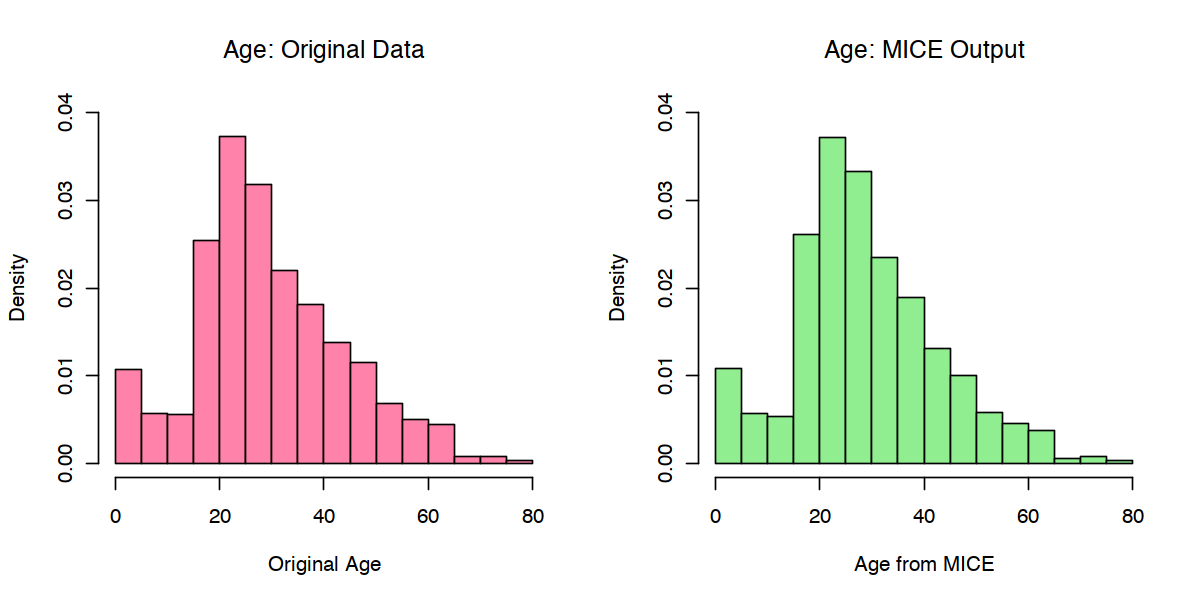

In [18]:
# Plot age distributions
par(mfrow=c(1,2))
hist(comp$Age, freq=F, main='Age: Original Data', 
  col='palevioletred1', ylim=c(0,0.04),xlab='Original Age')
hist(mice_output$Age, freq=F, main='Age: MICE Output', 
  col='lightgreen', ylim=c(0,0.04),xlab='Age from MICE')

In [19]:
comp$Age <- mice_output$Age

In [20]:
colSums(is.na(comp))

PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0           0 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0           0           0

## All missing values have been accounted for and data has been cleaned.

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,
891,1,1,1,1,1,1,1,1,1,1,1,1,0
418,1,1,1,1,1,1,1,1,1,1,1,0,1
,0,0,0,0,0,0,0,0,0,0,0,418,418


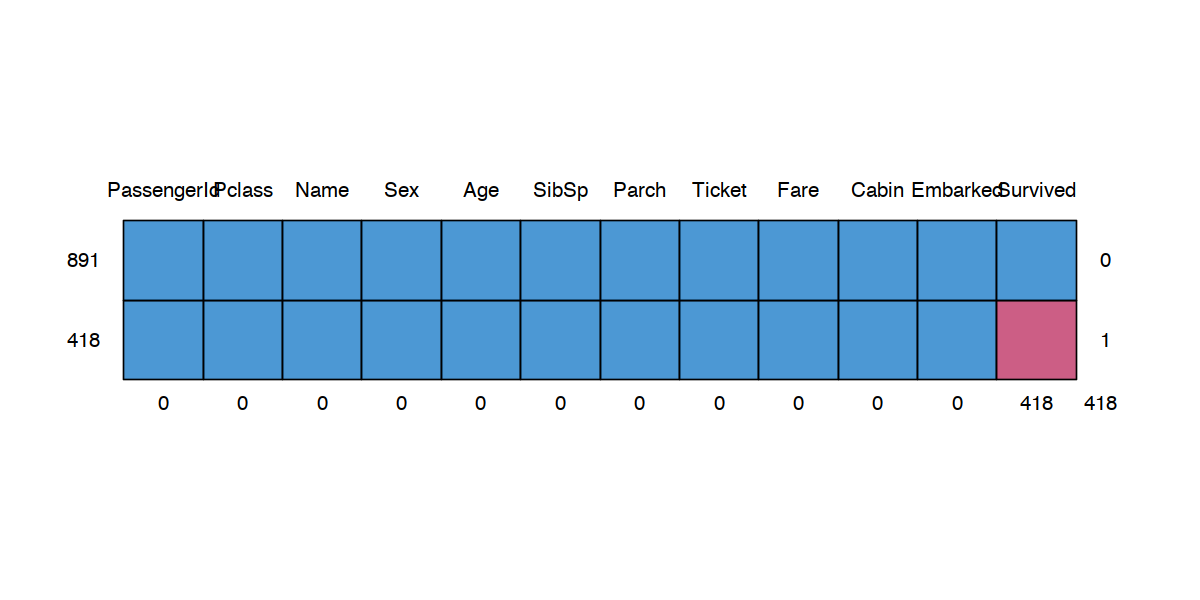

In [21]:
md.pattern(comp)

## Relationships
### Let's look at some relationships now that we have taken care of the missing values

In [22]:
sum(!is.na(comp$Survived))

[1] 891

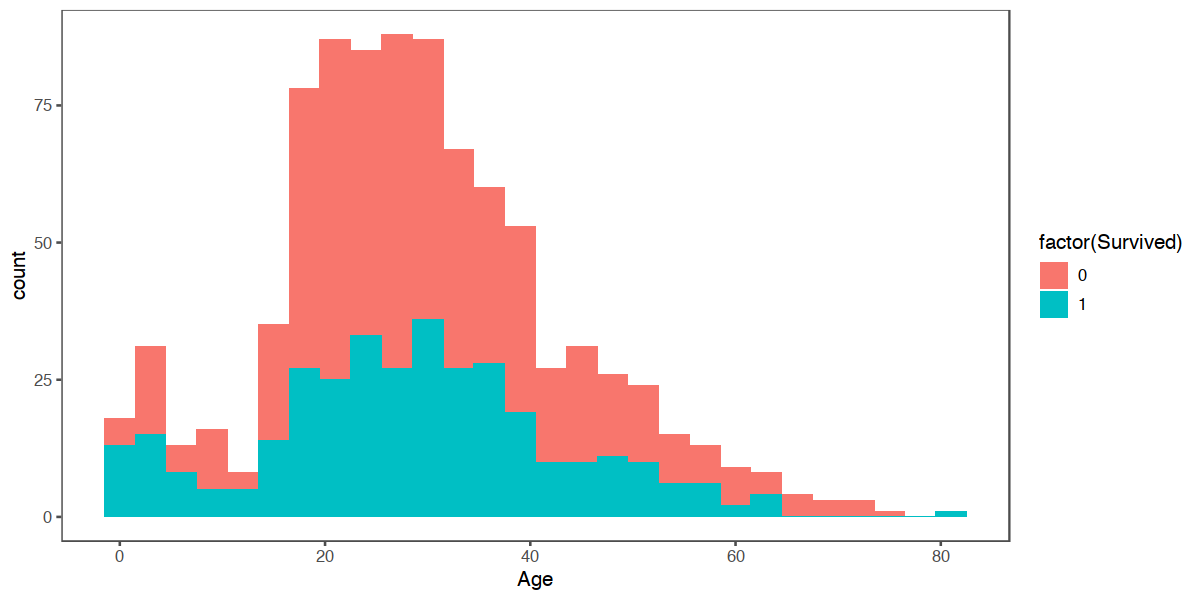

In [23]:
# Relationship between Age and survival:
ggplot(comp[1:891,], aes(Age, fill = factor(Survived))) + 
  geom_histogram(binwidth=3) + 
  theme_few()

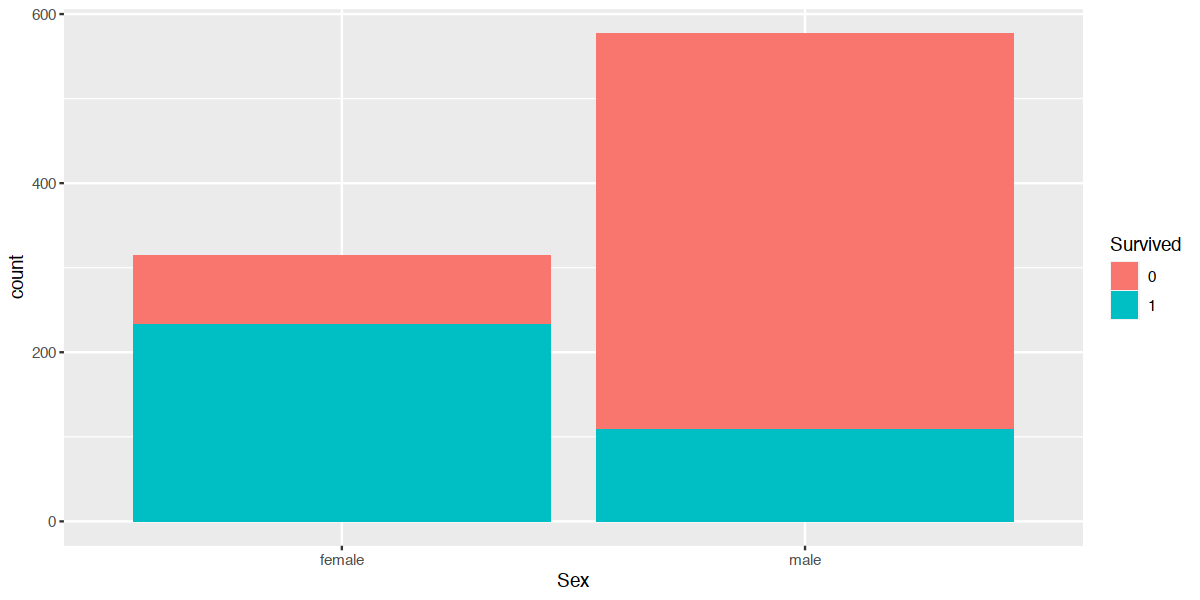

In [24]:
# Relationship between Sex and survival:
ggplot(data=comp[1:891,],aes(x=Sex,fill=Survived))+geom_bar()

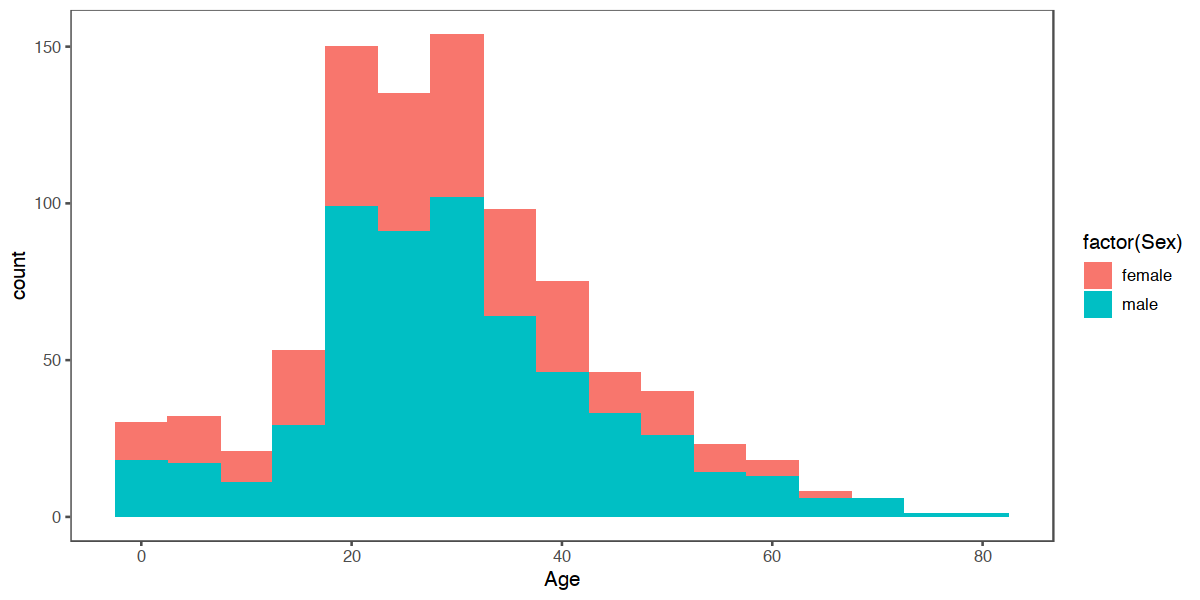

In [25]:
# Relationship between Age and sex:
ggplot(comp[1:891,], aes(Age, fill = factor(Sex))) + 
  geom_histogram(binwidth=5) + 
  theme_few()

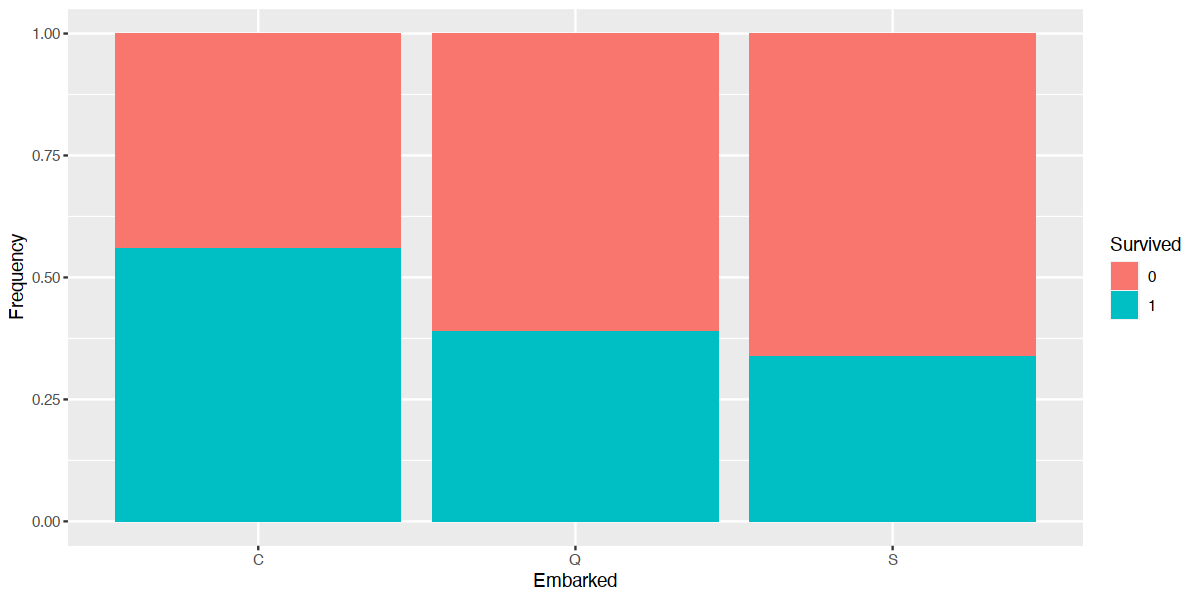

In [26]:
# Relationship between Embarked and survival:
ggplot(data = comp[1:891,],aes(x=Embarked,fill=Survived))+geom_bar(position="fill")+ylab("Frequency")

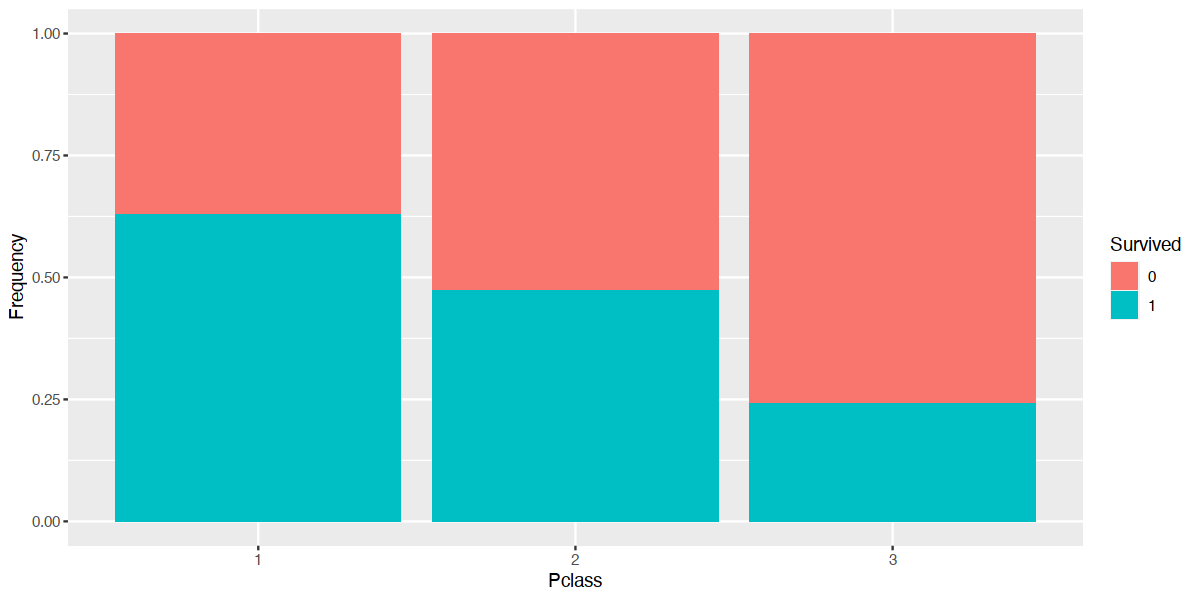

In [27]:
# Relationship between Survival and Pclass
ggplot(data = comp[1:891,],aes(x=Pclass,fill=Survived))+geom_bar(position="fill")+ylab("Frequency")

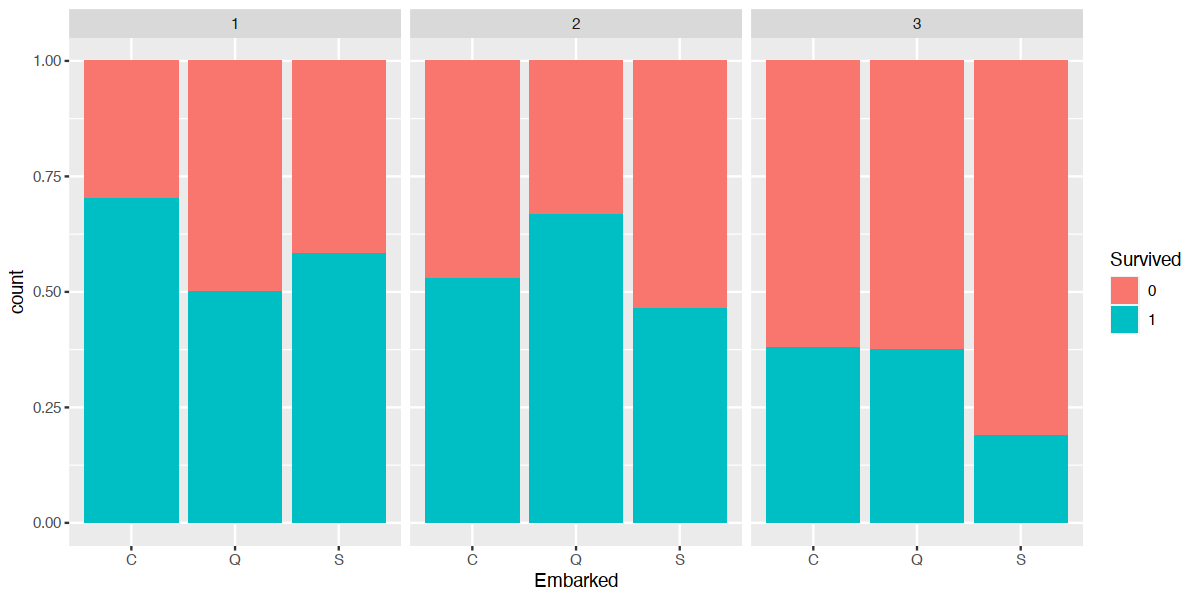

In [28]:
# Now, dividing the graph of Embarked by Pclass:
ggplot(data = comp[1:891,],aes(x=Embarked,fill=Survived))+geom_bar(position="fill")+facet_wrap(~Pclass)

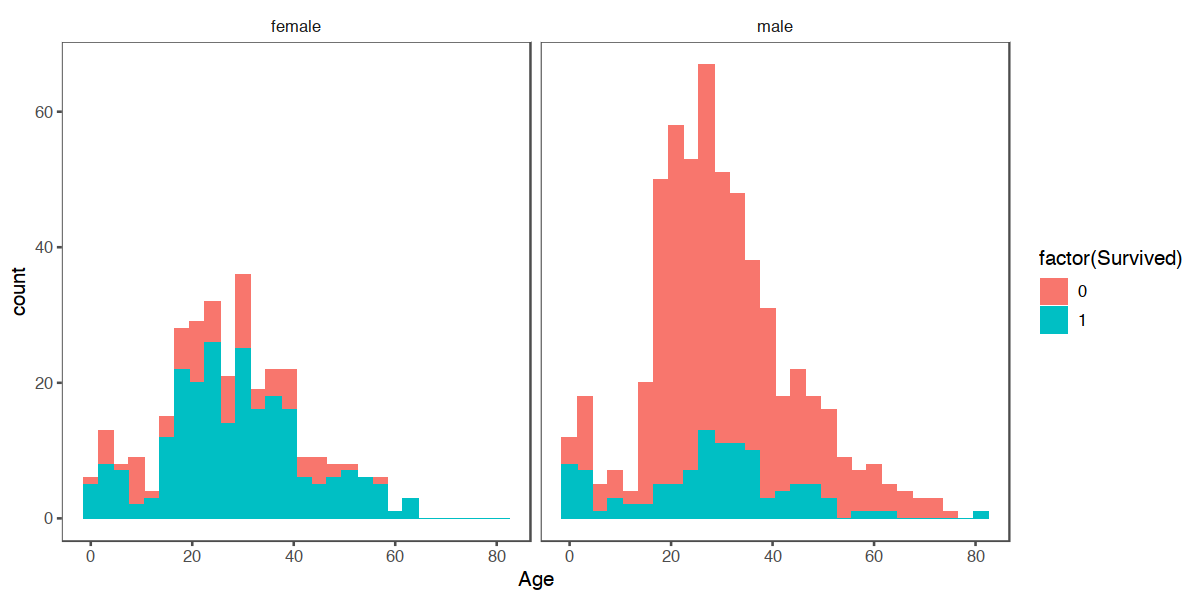

In [29]:
# Relationship between sex and survival:
ggplot(comp[1:891,], aes(Age, fill = factor(Survived))) + 
  geom_histogram(binwidth=3) + 
  facet_grid(.~Sex) + 
  theme_few()

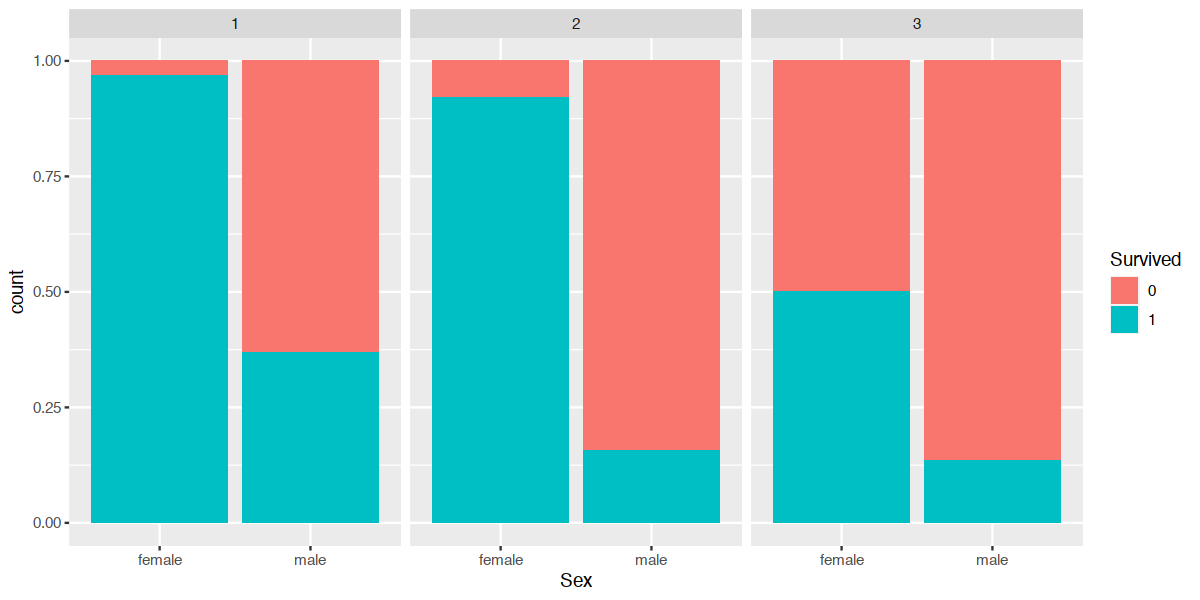

In [30]:
# Relationship between Sex and Survival by Pclass
ggplot(data = comp[1:891,],aes(x=Sex,fill=Survived))+geom_bar(position="fill")+facet_wrap(~Pclass)

Warning message:
“position_stack requires non-overlapping x intervals”

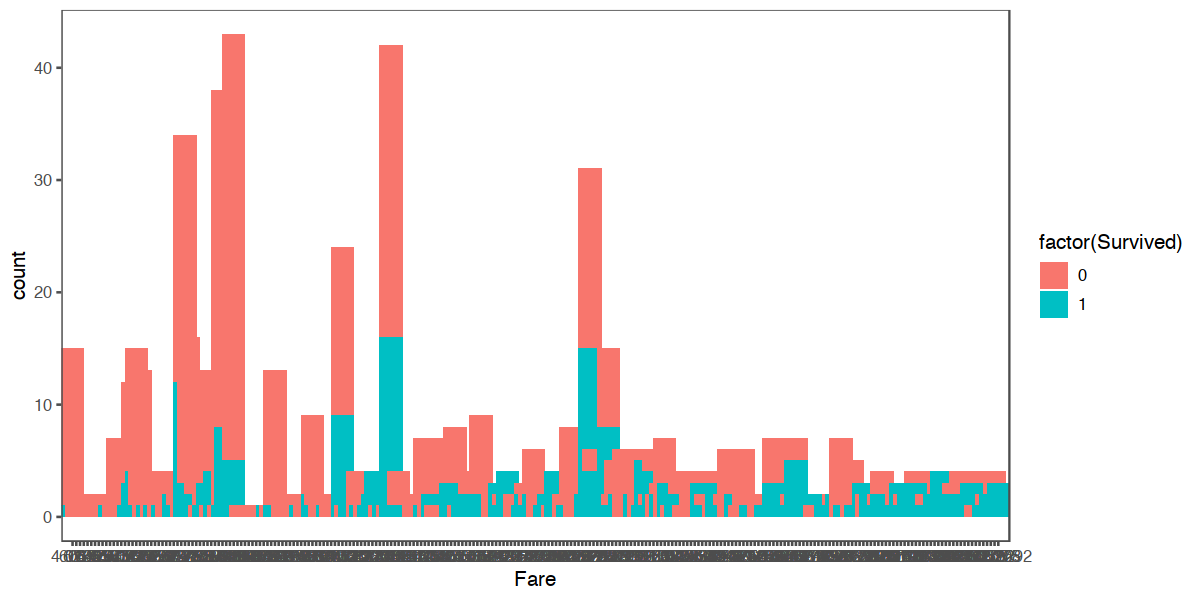

In [31]:
# Relationship between Fare and survival:

ggplot(comp[1:891,], aes(Fare, fill = factor(Survived))) + 
  geom_bar(width=6) + 
  theme_few()

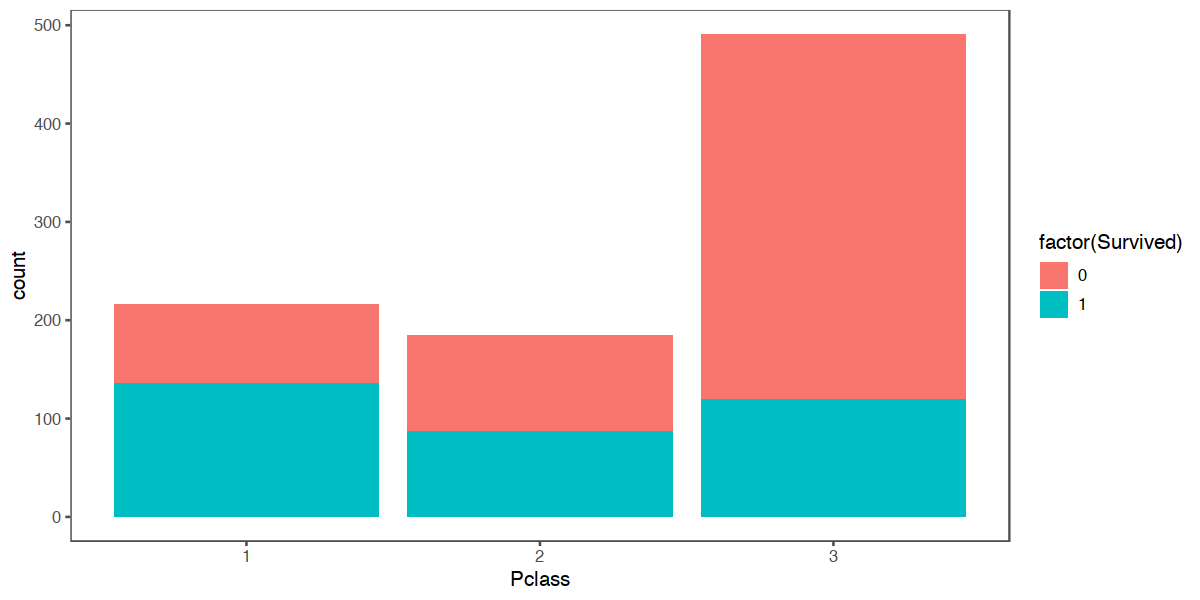

In [32]:
# Relationship between Pclass and survival:
ggplot(comp[1:891,], aes(Pclass, fill = factor(Survived))) + 
  geom_bar() + 
  theme_few()

## Predictions
### Using the data we have cleaned, we will predict the chance of survival based on other variables and features. 

In [33]:
indy <- createDataPartition(y=comp$Survived,
                               p=0.80, list=FALSE)
trainset <- comp[indy,]
testset <- comp[-indy,]

## Building the model: Logistic Regression is used here since its a simple regression model.

### 1. Logistic Regression

In [34]:
lrmodel <- glm(Survived ~ Pclass + Sex + Age + Embarked, data = trainset, family = 'binomial')
summary(lrmodel)


Call:
glm(formula = Survived ~ Pclass + Sex + Age + Embarked, family = "binomial", 
    data = trainset)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5034  -0.6883  -0.4003   0.6340   2.4296  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.943028   0.433342   9.099  < 2e-16 ***
Pclass2     -0.836517   0.299888  -2.789  0.00528 ** 
Pclass3     -2.293493   0.286222  -8.013 1.12e-15 ***
Sexmale     -2.515077   0.209684 -11.995  < 2e-16 ***
Age         -0.031844   0.007711  -4.129 3.64e-05 ***
EmbarkedQ   -0.312492   0.404072  -0.773  0.43931    
EmbarkedS   -0.790458   0.264264  -2.991  0.00278 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 950.86  on 713  degrees of freedom
Residual deviance: 642.13  on 707  degrees of freedom
  (335 observations deleted due to missingness)
AIC: 656.13

Number of Fisher Scoring iterations: 5

###  All the variables have a significant effect on the model.
### Evaluating:

In [36]:
pred <- predict(lrmodel, testset, type = 'response')
pred[pred > 0.5 ] <- 1
pred[pred < 0.5 | is.na(pred) ] <- 0
pred <- as.factor(pred)
confusionMatrix(pred,testset$Survived)$overall[1]

Accuracy 
0.8022599

# Accuracy of 80%.

### Logistic Regression is an okay model for this dataset. It can be made better by including/removing relevant/irrelevant variables. 